In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define the ODE systems
def fast_system(y, t, eps):
    x, y = y
    dxdt = eps
    dydt = x + y**2
    return [dxdt, dydt]

def slow_system(y, tau, eps):
    x, y = y
    dx_dtau = 1
    dy_dtau = (x + y**2) / eps
    return [dx_dtau, dy_dtau]

# Initial and ending points
x_init, y_init = -5, -5
x_end, y_end = 0, 2

# Time parameters
t_end = 10
tau_end = 4.8
eps = 0.01
t = np.linspace(0, t_end, 100)
tau = np.linspace(0, tau_end, 100)
t2  =  np.linspace(0,-t_end, 100)

# Convert numpy arrays to PyTorch tensors
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

# Neural network model for the fast system
num_nrn = 5

class FastSystemPINN(nn.Module):
    def __init__(self):
        super(FastSystemPINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Neural network model for the slow system
class SlowSystemPINN(nn.Module):
    def __init__(self):
        super(SlowSystemPINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class FastSystemPINN2(nn.Module):
    def __init__(self):
        super(FastSystemPINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

## The first plot:

In [3]:
phys_weight = 1

def loss_func_fast(model, t_tensor, x_init, y_init,\
                                   xf_end, yf_end, eps):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast = dx_dt - eps
    residual2_fast = dy_dt - (x_pred_fast + y_pred_fast**2)  
    
    residual3_fast = dx_dt
    
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) 
    physics_loss_fast = torch.mean(residual1_fast**2+ residual2_fast**2 + residual3_fast**2 )

    boundary_loss_fast = torch.square(x_pred_fast[-1] - xf_end) +\
                         torch.square(y_pred_fast[-1] - yf_end) 
        
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast +\
                      boundary_loss_fast 

    return total_loss_fast


def loss_func_slow(model, tau_tensor, xs_init, ys_init, xs_end, ys_end, eps):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)   
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_slow = dx_dtau  - 1
    residual2_slow =  x_pred_slow + y_pred_slow ** 2
    init_loss_slow = torch.square(x_pred_slow[0] - xs_init) +\
                     torch.square(y_pred_slow[0] - ys_init) 
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - xs_end) +\
                         torch.square(y_pred_slow[-1] - ys_end)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow

def loss_func_fast2(model, t2_tensor, x_end, y_end,\
                                   xf2_end, yf2_end, eps):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast2 = dx_dt2 - eps
    residual2_fast2 = dy_dt2 - (x_pred_fast2 + y_pred_fast2**2)     
    residual3_fast2 = dx_dt2 
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                     torch.square(y_pred_fast2[0] - y_end) 
    physics_loss_fast2 = torch.mean(residual1_fast2**2+ residual2_fast2**2 )

    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - xf2_end) +\
                         torch.square(y_pred_fast2[-1] - yf2_end) 
        
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 +\
                       boundary_loss_fast2 

    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    x_init, y_init, xf_end, yf_end,\
                    xs_init, ys_init, xs_end, ys_end,\
                    x_end, y_end, xf2_end, yf2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init,\
                                                   xf_end, yf_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               xs_init, ys_init, xs_end, ys_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end,\
                                                   xf2_end, yf2_end, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss



Epoch 0, Total Loss: 55.492580390455664
Epoch 1000, Total Loss: 5.0301416431791335
Epoch 2000, Total Loss: 0.9011888436705514
Epoch 3000, Total Loss: 0.1831146131393789
Epoch 4000, Total Loss: 0.09173395534845599
Epoch 5000, Total Loss: 0.041884543316033716
Epoch 6000, Total Loss: 0.015503030487170997
Epoch 7000, Total Loss: 0.005224354028442074
Epoch 8000, Total Loss: 0.0030527060607967787
Epoch 9000, Total Loss: 0.0022305969471411564
Epoch 10000, Total Loss: 0.0018651277559588808
Epoch 11000, Total Loss: 0.0016771632295483827
Epoch 12000, Total Loss: 0.0015794190577766445
Epoch 13000, Total Loss: 0.0015275903328052691
Epoch 14000, Total Loss: 0.001501152465028949
Epoch 15000, Total Loss: 0.0014844041272634762
Epoch 16000, Total Loss: 0.0014793692608437029
Epoch 17000, Total Loss: 0.001457053776071601
Epoch 18000, Total Loss: 0.0014471385505427947
Epoch 19000, Total Loss: 0.001442113886968044


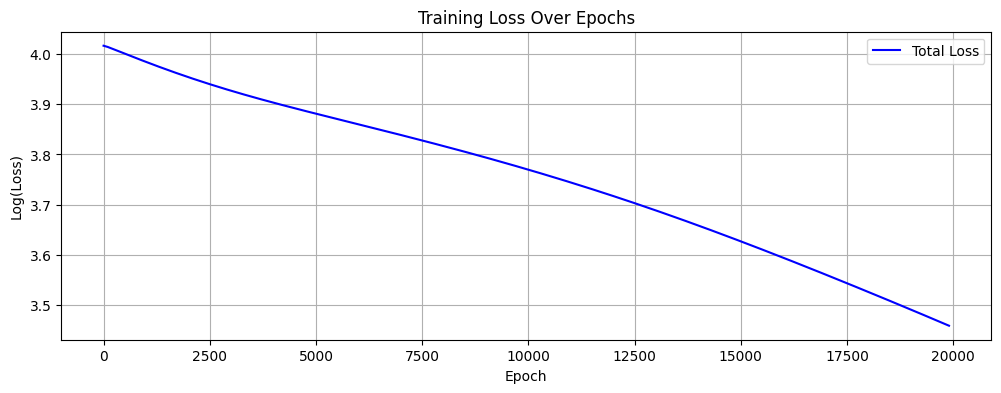

In [4]:
if __name__ == '__main__':
    model_fast  = FastSystemPINN().to(torch.float64)
    model_slow  = SlowSystemPINN().to(torch.float64)
    model_fast2 = FastSystemPINN2().to(torch.float64) 
    
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    
    loss_values = []
    epoch_num = 20000
    
    xf_end, yf_end = np.random.random(), np.random.random()   
    xs_init, ys_init = np.random.random(), np.random.random()
    xs_end, ys_end = np.random.random(), np.random.random()
    xf2_end, yf2_end = np.random.random(), np.random.random()

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, xf_end, yf_end,\
                                     xs_init, ys_init, xs_end, ys_end,\
                                     x_end, y_end, xf2_end, yf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()
        optimizer.step()
        
        with torch.no_grad():
            x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow = model_slow(tau_tensor).numpy().T
            x_pred_fast2, y_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end  = x_pred_slow[0], y_pred_slow[0]
            xs_init, ys_init = x_pred_fast[-1], y_pred_fast[-1]
            xs_end,  ys_end  = x_pred_fast2[-1], y_pred_fast2[-1]
            xf2_end, yf2_end = x_pred_slow[-1],  y_pred_slow[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
        
        loss_values.append(loss_total.item())

    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 100), np.log(loss_values[:epoch_num//100]), 'b', label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


## The second plot: 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Initial and ending points
u_init, v_init = -4, 0.0
u_end, v_end = 0, 2

# Time parameters
t_end = 10
tau_end = 4.0
eps = 0.01
t = np.linspace(0, t_end, 100)
tau = np.linspace(0, tau_end, 100)
t2  =  np.linspace(0,-t_end, 100)

# Convert numpy arrays to PyTorch tensors
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

# Neural network model for the fast system
num_nrn = 5

class Fast_System_PINN(nn.Module):
    def __init__(self):
        super(Fast_System_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        u = F.tanh(self.fc1(t))
        u = F.tanh(self.fc2(u))
        u = self.fc3(u)
        return u

# Neural network model for the slow system
class Slow_System_PINN(nn.Module):
    def __init__(self):
        super(Slow_System_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, tau):
        v = F.tanh(self.fc1(tau))
        v = F.tanh(self.fc2(v))
        v = self.fc3(v)
        return v

# Neural network model for the second fast system
class Fast_System_PINN2(nn.Module):
    def __init__(self):
        super(Fast_System_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        u = F.tanh(self.fc1(t))
        u = F.tanh(self.fc2(u))
        u = self.fc3(u)
        return u


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

phys_weight = 1

def loss_func_fast(model, t_tensor, u_init, v_init,\
                                   uf_end, vf_end, eps):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    u_pred_fast, v_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(u_pred_fast, requires_grad=True)  
    du_dt = torch.autograd.grad(u_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dt = torch.autograd.grad(v_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast = du_dt - eps
    residual2_fast = dv_dt - (u_pred_fast + v_pred_fast**2)  
    
    residual3_fast = du_dt
    
    init_loss_fast = torch.square(u_pred_fast[0] - u_init) +\
                     torch.square(v_pred_fast[0] - v_init) 
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 + residual3_fast**2)

    boundary_loss_fast = torch.square(u_pred_fast[-1] - uf_end) +\
                         torch.square(v_pred_fast[-1] - vf_end) 
        
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast +\
                      boundary_loss_fast 

    return total_loss_fast


def loss_func_slow(model, tau_tensor, us_init, vs_init, us_end, vs_end, eps):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    u_pred_slow, v_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)   
    
    ones = torch.ones_like(u_pred_slow, requires_grad=True)
    du_dtau = torch.autograd.grad(u_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dtau = torch.autograd.grad(v_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_slow = du_dtau  - 1
    residual2_slow = u_pred_slow + v_pred_slow ** 2
    
    init_loss_slow = torch.square(u_pred_slow[0] - us_init) +\
                     torch.square(v_pred_slow[0] - vs_init) 
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2)
    
    boundary_loss_slow = torch.square(u_pred_slow[-1] - us_end) +\
                         torch.square(v_pred_slow[-1] - vs_end)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow

def loss_func_fast2(model, t2_tensor, u_end, v_end,\
                                   uf2_end, vf2_end, eps):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    u_pred_fast2, v_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(u_pred_fast2, requires_grad=True)  
    du_dt2 = torch.autograd.grad(u_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dt2 = torch.autograd.grad(v_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast2 = du_dt2 - eps
    residual2_fast2 = dv_dt2 - (u_pred_fast2 + v_pred_fast2**2)     
    residual3_fast2 = du_dt2 
    
    init_loss_fast2 = torch.square(u_pred_fast2[0] - u_end) +\
                     torch.square(v_pred_fast2[0] - v_end) 
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2)

    boundary_loss_fast2 = torch.square(u_pred_fast2[-1] - uf2_end) +\
                         torch.square(v_pred_fast2[-1] - vf2_end) 
        
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 +\
                       boundary_loss_fast2 

    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    u_init, v_init, uf_end, vf_end,\
                    us_init, vs_init, us_end, vs_end,\
                    u_end, v_end, uf2_end, vf2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, u_init, v_init,\
                                                   uf_end, vf_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               us_init, vs_init, us_end, vs_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, u_end, v_end,\
                                                   uf2_end, vf2_end, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss


Epoch 0, Total Loss: 28.433126690263897
Epoch 1000, Total Loss: 0.7721632070355409
Epoch 2000, Total Loss: 0.03533987552305757
Epoch 3000, Total Loss: 0.010477416604570734
Epoch 4000, Total Loss: 0.004961415342507569
Epoch 5000, Total Loss: 0.002819733457550506
Epoch 6000, Total Loss: 0.0019278566016820466
Epoch 7000, Total Loss: 0.0015315424662889212
Epoch 8000, Total Loss: 0.0012733944008600864
Epoch 9000, Total Loss: 0.0010659664616389645
Epoch 10000, Total Loss: 0.0008970316370420473
Epoch 11000, Total Loss: 0.0007852013296946969
Epoch 12000, Total Loss: 0.0006773615404261728
Epoch 13000, Total Loss: 0.0006042783093304905
Epoch 14000, Total Loss: 0.0005503158779150335
Epoch 15000, Total Loss: 0.0005048789450396783
Epoch 16000, Total Loss: 0.00044573356068317894
Epoch 17000, Total Loss: 0.0004200136263781662
Epoch 18000, Total Loss: 0.00040782355973865655
Epoch 19000, Total Loss: 0.0004265760824742511


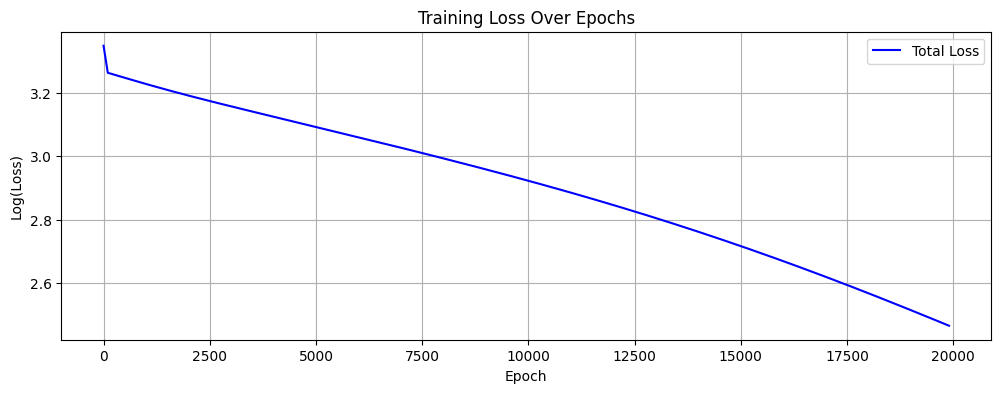

In [7]:
if __name__ == '__main__':
    model_fast  = Fast_System_PINN().to(torch.float64)
    model_slow  = Slow_System_PINN().to(torch.float64)
    model_fast2 = Fast_System_PINN2().to(torch.float64) 
    
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    
    loss_values = []
    epoch_num = 20000
    
    uf_end, vf_end = np.random.random(), np.random.random()   
    us_init, vs_init = np.random.random(), np.random.random()
    us_end, vs_end = np.random.random(), np.random.random()
    uf2_end, vf2_end = np.random.random(), np.random.random()

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     u_init, v_init, uf_end, vf_end,\
                                     us_init, vs_init, us_end, vs_end,\
                                     u_end, v_end, uf2_end, vf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()
        optimizer.step()
        
        with torch.no_grad():
            u_pred_fast, v_pred_fast = model_fast(t_tensor).numpy().T
            u_pred_slow, v_pred_slow = model_slow(tau_tensor).numpy().T
            u_pred_fast2, v_pred_fast2 = model_fast2(t2_tensor).numpy().T

            uf_end,  vf_end  = u_pred_slow[0], v_pred_slow[0]
            us_init, vs_init = u_pred_fast[-1], v_pred_fast[-1]
            us_end,  vs_end  = u_pred_fast2[-1], v_pred_fast2[-1]
            uf2_end, vf2_end = u_pred_slow[-1],  v_pred_slow[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
        
        loss_values.append(loss_total.item())

    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 100), np.log(loss_values[:epoch_num//100]), 'b', label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


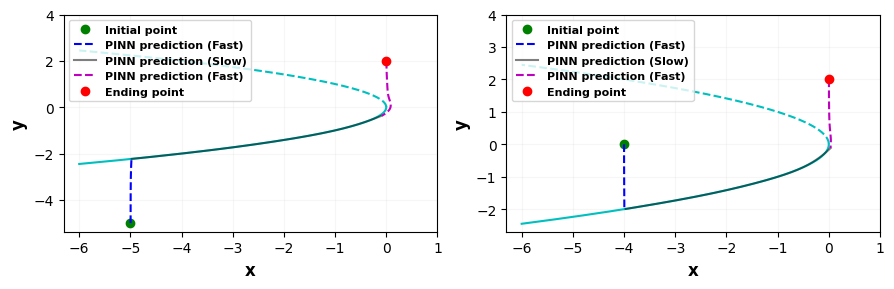

Shape of x_pred_fast: (100,)
Shape of x_pred_slow: (100,)
Shape of u_pred_fast: (100,)
Shape of u_pred_slow: (100,)


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

# Define the cyan curve
y_curve = np.linspace(-np.sqrt(6), np.sqrt(6), 400)
x_curve = -y_curve**2

# Separate the curve into two parts
y_curve_below = y_curve[y_curve <= 0]
x_curve_below = x_curve[y_curve <= 0]
y_curve_above = y_curve[y_curve > 0]
x_curve_above = x_curve[y_curve > 0]

# Plot the curve with different styles
ax1.plot(x_curve_below, y_curve_below, 'c-')  # Solid line below the origin
ax1.plot(x_curve_above, y_curve_above, 'c--')  # Dashed line above the origin

# Plot for the initial and predicted points
ax1.plot(x_init, y_init, 'go', label='Initial point')
ax1.plot(x_pred_fast, y_pred_fast, 'b--', label='PINN prediction (Fast)')
ax1.plot(x_pred_slow, y_pred_slow, 'k-', label='PINN prediction (Slow)', alpha=0.5)
ax1.plot(x_pred_fast2, y_pred_fast2, 'm--', label='PINN prediction (Fast)')
ax1.plot(x_end, y_end, 'ro', label='Ending point')

# Set labels and legend for the first subplot with thicker font
ax1.set_xlabel('x', fontsize=12, fontweight='bold')
ax1.set_ylabel('y', fontsize=12, fontweight='bold')
ax1.legend(prop={'size': 8, 'weight': 'bold'}, loc='upper left')
ax1.grid(True, alpha=0.1)
ax1.set_xlim( right=1)
ax1.set_ylim(top=4)

# Plot the curve with different styles in the second subplot
ax2.plot(x_curve_below, y_curve_below, 'c-')  # Solid line below the origin
ax2.plot(x_curve_above, y_curve_above, 'c--')  # Dashed line above the origin

# Plot for the initial and predicted points
ax2.plot(u_init, v_init, 'go', label='Initial point')
ax2.plot(u_pred_fast, v_pred_fast, 'b--', label='PINN prediction (Fast)')
ax2.plot(u_pred_slow, v_pred_slow, 'k-', label='PINN prediction (Slow)', alpha=0.5)
ax2.plot(u_pred_fast2, v_pred_fast2, 'm--', label='PINN prediction (Fast)')
ax2.plot(u_end, v_end, 'ro', label='Ending point')

# Set labels and legend for the second subplot with thicker font
ax2.set_xlabel('x', fontsize=12, fontweight='bold')
ax2.set_ylabel('y', fontsize=12, fontweight='bold')
ax2.legend(prop={'size': 8, 'weight': 'bold'}, loc='upper left')
ax2.grid(True, alpha=0.1)
ax2.set_xlim( right=1)
ax2.set_ylim(top=4)

plt.tight_layout()
plt.show()

# Print the shapes of the prediction arrays
shape_x_pred_fast = x_pred_fast.shape
print("Shape of x_pred_fast:", shape_x_pred_fast)
shape_x_pred_slow = x_pred_slow.shape
print("Shape of x_pred_slow:", shape_x_pred_slow)

shape_u_pred_fast = u_pred_fast.shape
print("Shape of u_pred_fast:", shape_u_pred_fast)
shape_u_pred_slow = u_pred_slow.shape
print("Shape of u_pred_slow:", shape_u_pred_slow)


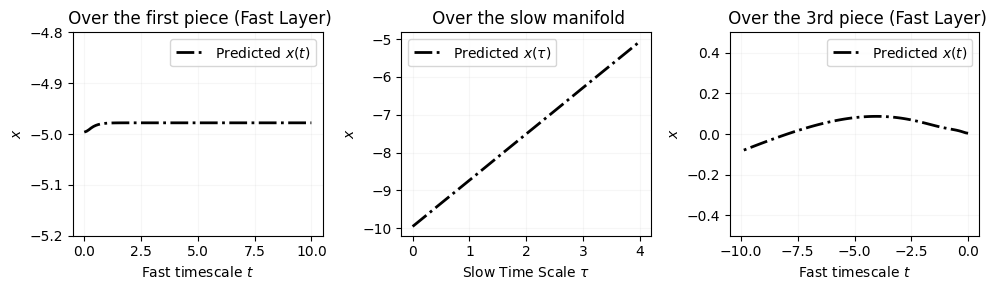

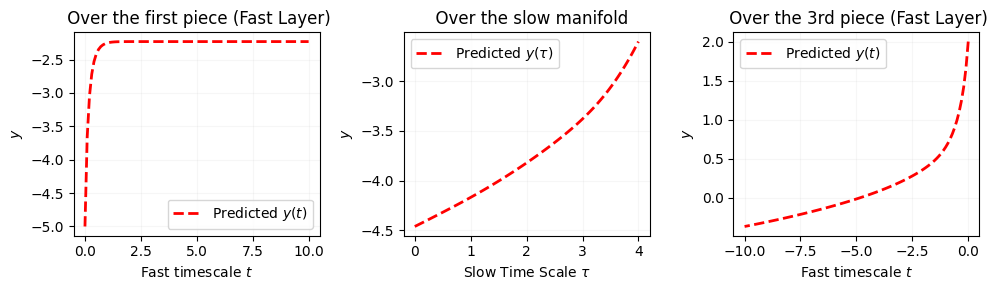

In [9]:
#########1st piece
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot(t, x_pred_fast, '-.', color='black', linewidth=2, label='Predicted $x(t)$')
plt.xlabel('Fast timescale $t$')
plt.grid(True, alpha=0.1)
plt.ylabel('$x$')
plt.ylim(-5.2, -4.8)
plt.title(' Over the first piece (Fast Layer)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, x_pred_slow + x_pred_fast[-1], '-.', color='black', linewidth=2, label='Predicted $x(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.grid(True, alpha=0.1)
plt.ylabel('$x$')
plt.title(' Over the slow manifold')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, x_pred_fast2 , '-.', color='black', linewidth=2, label='Predicted $x(t)$')
plt.xlabel('Fast timescale $t$')
plt.grid(True, alpha=0.1)
plt.ylabel('$x$')
plt.ylim(-0.5, 0.5)
plt.title(' Over the 3rd piece (Fast Layer)')
plt.legend()


plt.tight_layout()
plt.show()

########2nd piece
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot(t, y_pred_fast, 'r--', linewidth=2, label='Predicted $y(t)$')
plt.xlabel('Fast timescale $t$')
plt.grid(True, alpha=0.1)
plt.ylabel('$y$')
plt.title(' Over the first piece (Fast Layer)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, y_pred_slow + y_pred_fast[-1], 'r--', linewidth=2, label='Predicted $y(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$y$')
plt.grid(True, alpha=0.1)
#plt.ylim(-0.1, 0.1)
plt.title('  Over the slow manifold')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(t2, y_pred_fast2 , 'r--', linewidth=2, label='Predicted $y(t)$')
plt.xlabel('Fast timescale $t$')
plt.grid(True, alpha=0.1)
plt.ylabel('$y$')
plt.title(' Over the 3rd piece (Fast Layer)')
plt.legend()



plt.tight_layout()
plt.show()
